In [1]:
import os
import re
import csv

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import numpy as np
import math

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

In [2]:
#directory = "20230727"
directory = "20230810"
directory_2 = "20230804"
p = re.compile(r"\d\d\d")
instance_size_regex = re.compile(r"\d\d\d\d")

In [3]:
density_structure = {}
type_structure = {}

GROUNDING_TIME = "grounding_time"
GROUNDING_SIZE = "grounding_size"
TOTAL_TIME = "total_time"

GRINGO = "gringo"
IDLV = "idlv"
NEWGROUND_GRINGO = "newground-gringo"
NEWGROUND_IDLV = "newground-idlv"

grounder_types = [GRINGO, IDLV, NEWGROUND_GRINGO, NEWGROUND_IDLV]


file_types = [GROUNDING_TIME, GROUNDING_SIZE, TOTAL_TIME]


In [4]:
label_converter = {}
label_converter[GRINGO] = GRINGO
label_converter[IDLV] = GRINGO
label_converter[NEWGROUND_GRINGO] = "NaGG-Gringo"
label_converter[NEWGROUND_IDLV] = "NaGG-IDLV"

In [5]:
for grounder_type in grounder_types:
    type_structure[grounder_type] = {}
    for file_type in file_types:
        type_structure[grounder_type][file_type] = {}
        

In [6]:
folder_2_file_names = {}
for root_, dirs, files in os.walk(directory_2):
    for file in files:
        if not "log" in file and not "encoding" in file and not "additional" in file:
            folder_2_file_names[file[3:]] = file


In [7]:
# Parse all files into density_structure and type_structure
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.startswith("00"):
            continue
            
        result = p.search(file)
        
        if result is not None:
            density = result.group(0)
            
            if density not in density_structure:
                density_structure[density] = {}
                
            for file_type in file_types:
                if file_type in file:
                    density_structure[density][file_type] = {}
                    density_structure[density][file_type]["filename"] = file
                    density_structure[density][file_type]["density"] = density
                    density_structure[density][file_type]["type"] = file_type
                    file_data = pd.read_csv(os.path.join(directory, file), delimiter=',')   
                    
                    #splits = file.split("with_aggregates")
                    
                    #resulting_file_name = "02".join(splits)
                    
                    resulting_file_name = file
                    
                    other_file_name = folder_2_file_names[resulting_file_name[3:]]
                    
                    file_data_2 = pd.read_csv(os.path.join(directory_2, other_file_name), delimiter=',')
                    
                    file_data = pd.concat([file_data, file_data_2], ignore_index = True)
                    
                    density_structure[density][file_type]["csv"] = file_data
                    
                    for column_name in list(file_data.columns):
                        for grounder_type in grounder_types:
                            if column_name.startswith(grounder_type) and "timeout-occurred" not in column_name and "timeout-occured" not in column_name:
                                if "instance_size" not in type_structure[grounder_type][file_type]:
                                    type_structure[grounder_type][file_type]["instance_size"] = []
                                if "instance_density" not in type_structure[grounder_type][file_type]:
                                    type_structure[grounder_type][file_type]["instance_density"] = []
                                if column_name not in type_structure[grounder_type][file_type]:
                                    type_structure[grounder_type][file_type][column_name] = []
                                    
                                
                                list_instances = list(file_data["instance"])
                    
                                density_list = [int(density)] * len(list_instances)

                                instance_size_list = [int((instance_size_regex.search(instance)).group(0)) for instance in list_instances]
                                
                                    
                                type_structure[grounder_type][file_type]["instance_size"] += instance_size_list
                                type_structure[grounder_type][file_type]["instance_density"] += density_list
                                
                                raw_column_data = list(file_data[column_name])
                                if "duration" in column_name:
                                    parsed_column_data = [time if float(time) < 10800 else -1 for time in raw_column_data]
                                elif "size" in column_name:
                                    parsed_column_data = [float(size)/1024 if float(size) <= 32*(math.pow(10,6)) and float(size) > 0 else -1 for size in raw_column_data]
                                else:
                                    print("THIS SHOULD NEVER HAPPEN!")

                                type_structure[grounder_type][file_type][column_name] += parsed_column_data

                        


In [8]:
for grounder_type in grounder_types:
    for file_type in file_types:        
        instance_size = type_structure[grounder_type][file_type]["instance_size"]
        instance_density = type_structure[grounder_type][file_type]["instance_density"]
        
        special_name = None
        for key in type_structure[grounder_type][file_type].keys():
            if "instance" not in key and "data_frame" not in key:
                special_name = key
    
        special = type_structure[grounder_type][file_type][special_name]
        
        data_dict = {
            "instance_size":instance_size,
            "instance_density":instance_density,
            special_name: special
        }
        

        data_frame = pd.DataFrame(data_dict)
        type_structure[grounder_type][file_type]["data_frame"] = data_frame
        
        cpy_df = data_frame.copy()
        cpy_df = cpy_df.drop(cpy_df[cpy_df[special_name] < 0].index)
        type_structure[grounder_type][file_type]["parsed_df"] = cpy_df        

In [9]:
combinations = [((GRINGO,GROUNDING_SIZE),(GRINGO,GROUNDING_TIME), "grounding time [s] (left half)", label_converter[GRINGO]),
               ((IDLV,GROUNDING_SIZE),(IDLV,GROUNDING_TIME), "grounding time [s] (left half)", label_converter[IDLV]),
               ((NEWGROUND_GRINGO,GROUNDING_SIZE),(NEWGROUND_GRINGO,GROUNDING_TIME), "grounding time [s] (left half)", label_converter[NEWGROUND_GRINGO]),
               ((NEWGROUND_IDLV,GROUNDING_SIZE),(NEWGROUND_IDLV,GROUNDING_TIME), "grounding time [s] (left half)", label_converter[NEWGROUND_IDLV]),
               ((GRINGO,GROUNDING_SIZE),(GRINGO,TOTAL_TIME), "total solving time [s] (left half)", label_converter[GRINGO]),
               ((IDLV,GROUNDING_SIZE),(IDLV,TOTAL_TIME), "total solving time [s] (left half)", label_converter[IDLV]),
               ((NEWGROUND_GRINGO,GROUNDING_SIZE),(NEWGROUND_GRINGO,TOTAL_TIME), "total solving time [s] (left half)", label_converter[NEWGROUND_GRINGO]),
                ((NEWGROUND_IDLV,GROUNDING_SIZE),(NEWGROUND_IDLV,TOTAL_TIME), "total solving time [s] (left half)", label_converter[NEWGROUND_IDLV])]


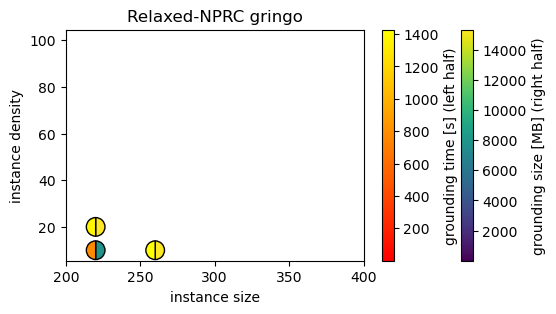

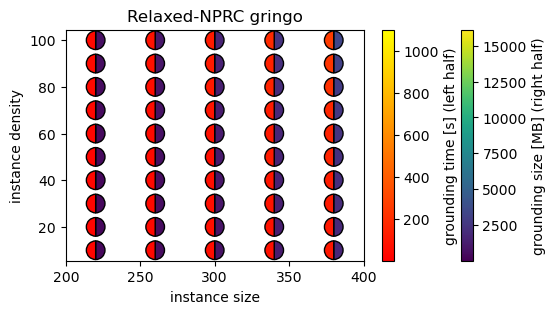

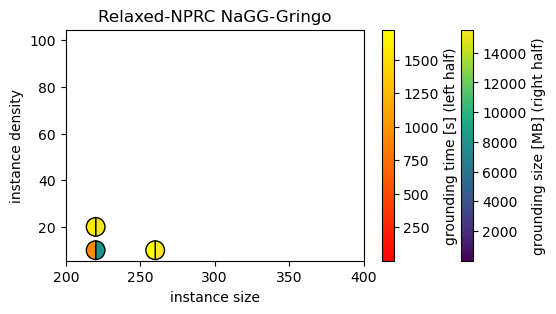

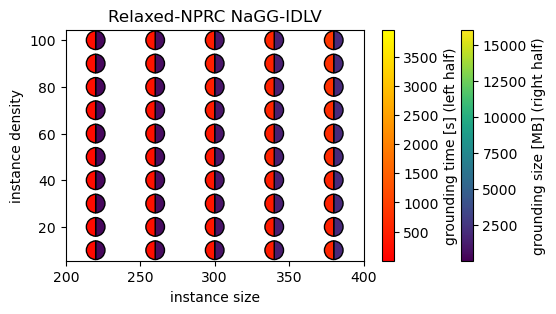

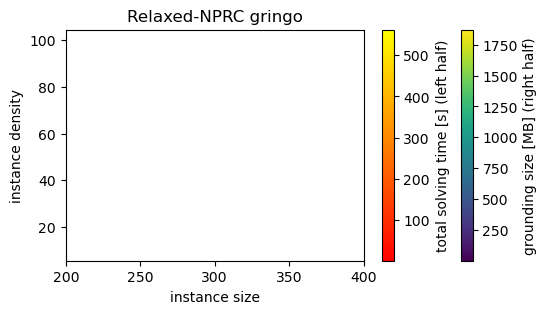

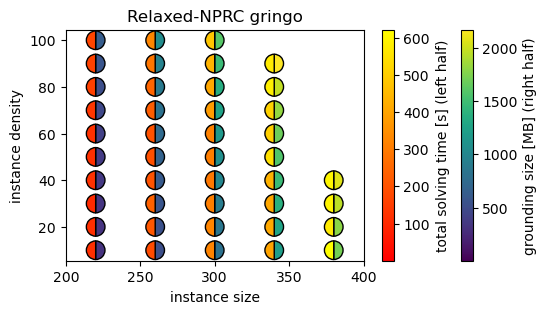

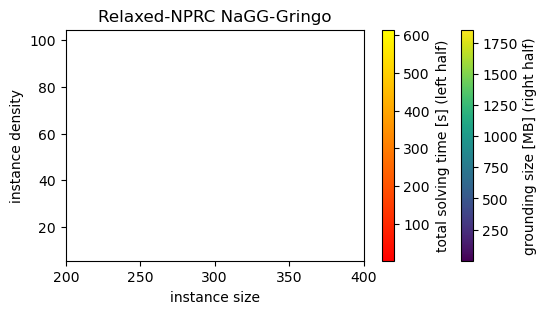

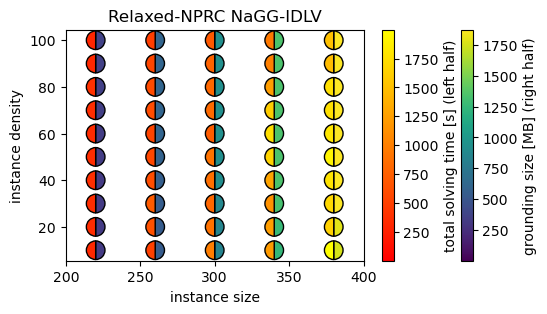

In [10]:
fix_color_bar = False

for combination in combinations:
    label = f"Relaxed-NPRC {combination[3]}"
    plot_file_name = f"NPRC_{combination[0][0]}_{combination[0][1]}_{combination[1][1]}.pdf"
    
    data_frame = (type_structure[combination[0][0]][combination[0][1]]["parsed_df"]).copy()
    time_frame = (type_structure[combination[1][0]][combination[1][1]]["parsed_df"]).copy()
    
    
    data_frame_size_density = []
    for index, row in data_frame.iterrows():
        data_frame_size_density.append((row["instance_size"], row["instance_density"]))
        
    time_frame_size_density = []
    for index, row in time_frame.iterrows():
        time_frame_size_density.append((row["instance_size"], row["instance_density"]))
        
    intersected_instances = list(set(data_frame_size_density).intersection(set(time_frame_size_density)))   
    
    
    marked_deletion_data = []
    for index, row in data_frame.iterrows():
        if ((row["instance_size"], row["instance_density"])) not in intersected_instances:
            marked_deletion_data.append(index)
        
    marked_deletion_time = []
    for index, row in time_frame.iterrows():
        if ((row["instance_size"], row["instance_density"])) not in intersected_instances:
            marked_deletion_time.append(index)
            
    data_frame = data_frame.drop(marked_deletion_data)
    time_frame = time_frame.drop(marked_deletion_time)    
    
    #data_frame = data_frame[~data_frame["instance_size"].isin([310,320,340,350,370,380,400,410,420,430,440,450])]    
    #time_frame = time_frame[~time_frame["instance_size"].isin([310,320,340,350,370,380,400,410,420,430,440,450])]
    
    #data_frame = data_frame[~data_frame["instance_size"].isin([410,420,430,440,450])]    
    #time_frame = time_frame[~time_frame["instance_size"].isin([410,420,430,440,450])]
    
    plotsize = (6, 3)
    
    plt.figure(figsize=plotsize)
    
    
    if fix_color_bar == False:
        data_X = list(data_frame["instance_size"])
        data_Y = list(data_frame["instance_density"])
        data_Z = list(data_frame.iloc[:,2])
    else:
        # The additional ''fake'' example (460, 90, 32000) is added to generate static color ranges
        data_X = list(data_frame["instance_size"])+[460]
        data_Y = list(data_frame["instance_density"])+[90]
        data_Z = list(data_frame.iloc[:,2])+[32000]
    
    plt.scatter(data_X, data_Y, linewidth=1,edgecolor="black",s=180,c=data_Z,marker=MarkerStyle("o", fillstyle="right"), cmap="viridis") #viridis") #,marker="*",color='blue')
    cbar=plt.colorbar()
    cbar.set_label("grounding size [MB] (right half)", rotation=90)

    if fix_color_bar == False:
        time_X = list(time_frame["instance_size"])
        time_Y = list(time_frame["instance_density"])
        time_Z = list(time_frame.iloc[:,2])
    else:
        # The additional ''fake'' example (460, 90, 1800) is added to generate static color ranges
        time_X = list(time_frame["instance_size"])+[460]
        time_Y = list(time_frame["instance_density"])+[90]
        time_Z = list(time_frame.iloc[:,2])+[1800]
    
    plt.scatter(time_X, time_Y, linewidth=1,edgecolor="black",s=180,c=time_Z,marker=MarkerStyle("o", fillstyle="left"), cmap="autumn") #plasma") #autumn") #viridis") #,marker="*",color='blue')
    cbar=plt.colorbar()
    cbar.set_label(combination[2], rotation=90)
    
    plt.title("" + label)

    plt.xlabel("instance size") #tmeasures[a])
    plt.ylabel("instance density") #tmeasures[b])
    plt.xlim([200, 400])

    plt.show()
    #plt.savefig(plot_file_name, bbox_inches='tight', transparent=True)
    plt.close('all')

In [11]:
list(type_structure[IDLV].keys())

['grounding_time', 'grounding_size', 'total_time']

In [12]:
looked_at = [IDLV, NEWGROUND_IDLV]

method = "grounding_size"
#method = "grounding_time"
#method = "total"

if method == "grounding_size":
    struct = type_structure[NEWGROUND_IDLV]["grounding_size"]
    newground_idlv = [(struct["instance_size"][i],struct["instance_density"][i],struct["newground-idlv-size"][i]) for i in range(len(struct["instance_size"]))]

    struct = type_structure[IDLV]["grounding_size"]
    idlv = [(struct["instance_size"][i],struct["instance_density"][i],struct["idlv-size"][i]) for i in range(len(struct["instance_size"]))]
    
elif method == "grounding_time":
    struct = type_structure[NEWGROUND_IDLV]["grounding_time"]
    newground_idlv = [(struct["instance_size"][i],struct["instance_density"][i],struct["newground-idlv-duration"][i]) for i in range(len(struct["instance_size"]))]

    #struct = type_structure[IDLV]["grounding_size"]
    struct = type_structure[IDLV]["grounding_time"]
    idlv = [(struct["instance_size"][i],struct["instance_density"][i],struct["idlv-duration"][i]) for i in range(len(struct["instance_size"]))]
    
elif method == "total":
    struct = type_structure[NEWGROUND_IDLV]["total_time"]
    newground_idlv = [(struct["instance_size"][i],struct["instance_density"][i],struct["newground-idlv-duration"][i]) for i in range(len(struct["instance_size"]))]

    struct = type_structure[IDLV]["total_time"]
    idlv = [(struct["instance_size"][i],struct["instance_density"][i],struct["idlv-duration"][i]) for i in range(len(struct["instance_size"]))]    
    
newground_idlv.sort()
idlv.sort()

In [13]:
idlv_sorted = []
nag_sorted = []

version2 = False

for idlv_item in idlv:
    for nag_item in newground_idlv:
        if idlv_item[0] == nag_item[0] and idlv_item[1] == nag_item[1]:
            
            if idlv_item[2] > 0 and nag_item[2] > 0:
                idlv_sorted.append(idlv_item[2])
                nag_sorted.append(nag_item[2])

            if not version2:
                #timeout = 10800
                timeout = 32000

                if idlv_item[2] > 0:# or idlv_item[2] >= timeout:
                    idlv_sorted.append(idlv_item[2])
                else:
                    idlv_sorted.append(timeout)

                if nag_item[2] > 0:# or nag_item[2] >= timeout:
                    nag_sorted.append(nag_item[2])
                else:
                    nag_sorted.append(timeout)

                #combined.append((idlv_item[2],nag_item[2]))



idlv_sorted.sort()
nag_sorted.sort()

In [14]:
for i in range(len(nag_sorted)):
    if idlv_sorted[i] > 31000 and nag_sorted[i] < 5000:
        print(i)
        print(idlv_sorted[i])
        print(nag_sorted[i])

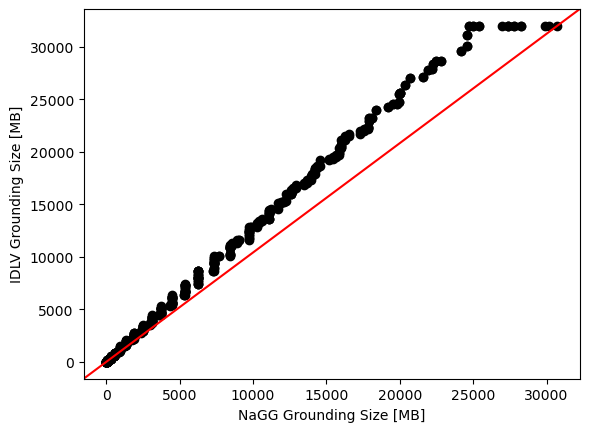

In [21]:
fig, ax = plt.subplots()
ax.scatter(nag_sorted,idlv_sorted, c='black')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
#plt.title("Grounding Size Scatter")
plt.xlabel("NaGG Grounding Size [MB]")
plt.ylabel("IDLV Grounding Size [MB]")
plt.yticks(np.arange(0, 32000, 5000))
plt.xticks(np.arange(0, 32000, 5000))

#plt.show()
plt.savefig("gs_scatter.svg")

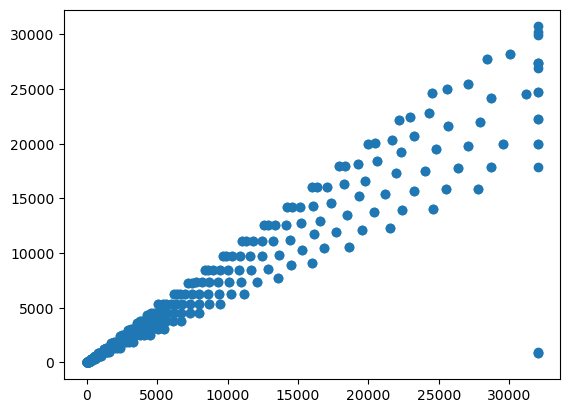

In [61]:
plt.scatter(idlv_sorted, nag_sorted)

In [14]:
type_structure['newground-idlv']['total_time']

{'instance_size': [20,
  60,
  100,
  140,
  180,
  220,
  260,
  300,
  340,
  380,
  420,
  450,
  480,
  510,
  540,
  570,
  600,
  630,
  660,
  690,
  720,
  750,
  780,
  810,
  20,
  60,
  100,
  140,
  180,
  220,
  260,
  300,
  340,
  380,
  420,
  450,
  480,
  510,
  540,
  570,
  600,
  630,
  660,
  690,
  720,
  750,
  780,
  810,
  20,
  60,
  100,
  140,
  180,
  220,
  260,
  300,
  340,
  380,
  420,
  450,
  480,
  510,
  540,
  570,
  600,
  630,
  660,
  690,
  720,
  750,
  780,
  810,
  840,
  870,
  900,
  20,
  60,
  100,
  140,
  180,
  220,
  260,
  300,
  340,
  380,
  420,
  450,
  480,
  510,
  540,
  570,
  600,
  630,
  660,
  690,
  720,
  750,
  780,
  810,
  840,
  870,
  900,
  20,
  60,
  100,
  140,
  180,
  220,
  260,
  300,
  340,
  380,
  420,
  450,
  480,
  510,
  540,
  570,
  600,
  630,
  660,
  690,
  720,
  750,
  780,
  810,
  840,
  870,
  900,
  930,
  960,
  20,
  60,
  100,
  140,
  180,
  220,
  260,
  300,
  340,
  380,
  420,
 